# Biodiversity Intactness Index change in Phoenix, AZ 

### Author: Kimberlee Wong
### Link to [Repository](https://github.com/kimberleewong/eds220-biodiversity-intactness)

## About

### Purpose
This notebook shows the process of using both a shapefile and a collection from the Microsoft Planetary Computer STAC catalog to visualize differences in the Biodiversity Intactness Index in Phoenix, Arizona from 2017 to 2020. Percentages were calculated and then visualized. 

### Highlights

- Using rioxr to import the Biodiversity Intactness Index  data and access its attributes
- Using a basemap to contextualize a shapefile
- Combining vector and raster data to make one map

### About the Data

The biodiversity intactness data comes from Microsoft Planetary Computer Data Catalogue.

The Arizona shapefile, that was filtered to Phoenix in this notebook, comes from the United States Census Bureau. 
### References

Microsoft Planetary Computer Data Catalogue, Biodiversity Intactness. Available from: https://planetarycomputer.microsoft.com/dataset/io-biodiversity Access date: December 7, 2024.

United States Census Bureau. 2020 version. Available from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php Access date: December 7, 2024

## Import Libraries and Load Data

In [39]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
import contextily as ctx
from shapely.geometry import box # To create polygon bounding box

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

import matplotlib.patches as mpatches # To create a custom legend

pd.set_option("display.max.columns", None) # To see all columns

arizona = gpd.read_file(os.path.join('data', 'tl_2020_04_cousub','tl_2020_04_cousub.shp'))

## Exploration of Arizona Shapefile

<Axes: >

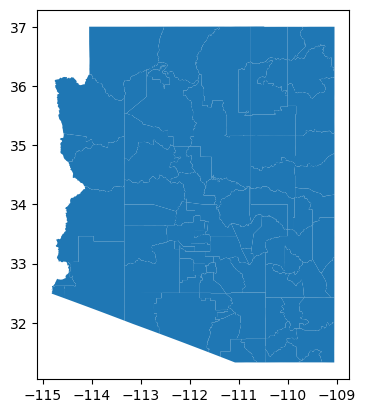

In [2]:
# Visualize Arizona
arizona.plot()

In [3]:
# Look at first three rows
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [4]:
print('CRS: ', arizona.crs)

print(f"ellipsoid: {arizona.crs.ellipsoid}")

print(f"datum: {arizona.crs.datum}")

# Set the label width to 25 characters, aligning the answers
print(f"{'Is the CRS geographic?:':<25} {arizona.crs.is_geographic}")
print(f"{'Is the CRS projected?:':<25} {arizona.crs.is_projected}")

CRS:  EPSG:4269
ellipsoid: GRS 1980
datum: North American Datum 1983
Is the CRS geographic?:   True
Is the CRS projected?:    False


After initial exploration of the Arizona shapefile, we can see that its CRS is EPSG:4269 and geographic. This is important to note for visualization purposes, so CRSs can match up. Because we need a Phoenix boundary, we can use the 'NAME' column as seen in the head of the geodataframe to filter our original data. 

In [5]:
# Create Phoenix shapefile by filtering arizona
phoenix_shp = arizona[arizona['NAME'] == 'Phoenix']
phoenix_shp

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

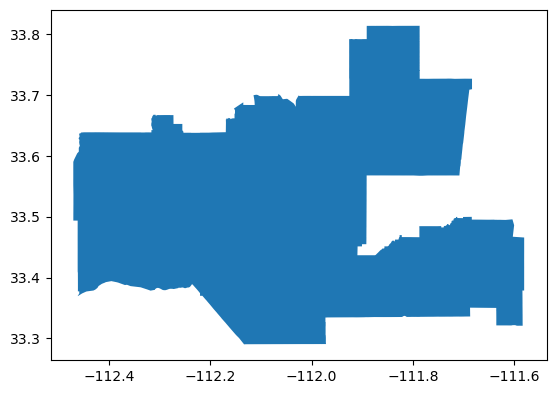

In [6]:
# Plot the new shapefile to make sure it looks correct
phoenix_shp.plot()

## Exploration of Microsoft Planetary Catalog

### Access

In [7]:
# Biodiversity Intactness Index (BII) Time Series Collection #

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Explore catalog metadata

In [8]:
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [9]:
# Get collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


After accessing the catalog, we found the title and its description. We also found that there are a total of 124 collections, and printed out the first ten. Now, we can look at the specific collection we want with our desired bounding box and time range.

## Access Biodiversity Intactness Index

In [10]:
# Access the specific 'io_biodiversity' collection #

# Temporal range of interest
time_range = "2017-01-01/2023-01-01"

# Set bounding box given
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

In [11]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [12]:
items

By viewing items, we can see the search matched how many items there are -- 4.

In [13]:
# Select the items we want for years 2020 and 2017
item_2020 = items[0]

item_2017 = items[3]

In [14]:
# Print item_2017 ID and properties
print('ID:' , item_2017.id)
item_2017.properties

ID: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [15]:
# Print item_2017 ID and properties
print('ID:' , item_2020.id)
item_2020.properties

ID: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [16]:
# Print each asset key
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [17]:
# Plot rendered preview of 2017
Image(url=item_2017.assets['rendered_preview'].href, width=500)

In [18]:
# Open the raster data from our 2017 and 2020 items
phoenix_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

## Visualize Phoenix and its greater context

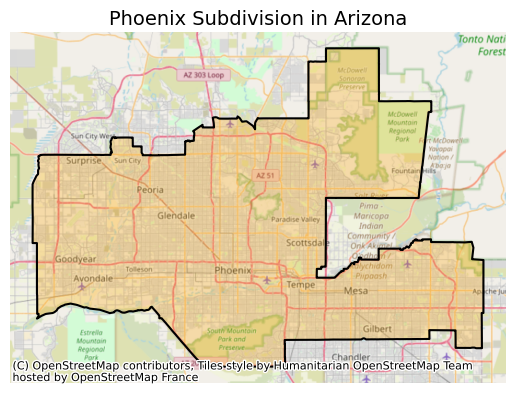

In [20]:
# Plot Phoenix on top of a basemap for contextualization. # 

# Initialize figure
fig, ax = plt.subplots()

# Remove the axis for a cleaner map
ax.axis('off')

# Plot Phoenix boundary
phoenix_shp.boundary.plot(ax=ax,
                          color = 'black')

# Plot Phoenix fill
phoenix_shp.plot(ax=ax, 
                color='orange',
                alpha=0.28)

# Add a basemap with a specified CRS to match Phoenix
ctx.add_basemap(ax, crs = phoenix_shp.crs)  

# Set title and axes labels
ax.set_title('Phoenix Subdivision in Arizona',
            fontsize=14)

plt.show()

## Calculate Percentage of Phoenix Subdivision w/ BII of at least 0.75 in 2017 and 2020
The goal is to find the areas within the Phoenix subdivision that have lost biodiversity between 2017 and 2020, and we're doing this by finding which areas (in each year) have a biodiversity index of at least 0.75. 

### Match CRSs

In [22]:
# Print out the CRSs
print('CRS: ', phoenix_shp.crs)

print('CRS: ', phoenix_2017.rio.crs)

print('CRS: ', phoenix_2020.rio.crs)

CRS:  EPSG:4269
CRS:  EPSG:4326
CRS:  EPSG:4326


In [25]:
# Change Phoenix shapefile to match the other two
phoenix_shp = phoenix_shp.to_crs(phoenix_2017.rio.crs)

# Add assert to ensure it worked
assert phoenix_shp.crs == phoenix_2017.rio.crs

### Clip the rasters to match the Phoenix bounding box

In [27]:
# Assign empty cells to nan
phoenix_2017 = phoenix_2017.rio.write_nodata(np.nan)

# Clip the 2017 raster to the phoenix bounding box
phoenix_2017_clip = (phoenix_2017.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )

In [28]:
# Assign empty cells to nan
phoenix_2020 = phoenix_2020.rio.write_nodata(np.nan)

# Clip the 2020 raster to the phoenix bounding box
phoenix_2020_clip = (phoenix_2020.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )

### Raster Algebra

In [29]:
# Sum the number of pixels above 0.75 for each year
area_bii_2017 = (phoenix_2017_clip >= 0.75).sum().item()
area_bii_2020 = (phoenix_2020_clip >= 0.75).sum().item()

In [30]:
# Count the number of pixels total for each year
total_bii_2017 = phoenix_2017_clip.count().item()
total_bii_2020 = phoenix_2020_clip.count().item()

In [31]:
# Calculate the percentage of the total area 
percentage_bii_2017 = (area_bii_2017 / total_bii_2017) * 100
percentage_bii_2020 = (area_bii_2020 / total_bii_2020) * 100

print(f"Percentage of area with BII of >= 0.75 in 2017: {percentage_bii_2017:.2f}%")
print(f"Percentage of area with BII of >= 0.75 in 2020: {percentage_bii_2020:.2f}%")

Percentage of area with BII of >= 0.75 in 2017: 7.13%
Percentage of area with BII of >= 0.75 in 2020: 6.49%


## Visualize the area with BII>=0.75 in 2017 that was lost by 2020
Now that we have the numbers, we should be able to visualize the area of BII >= 0.75 that existed in 2017 that was lost by 2020. We can create a difference. 

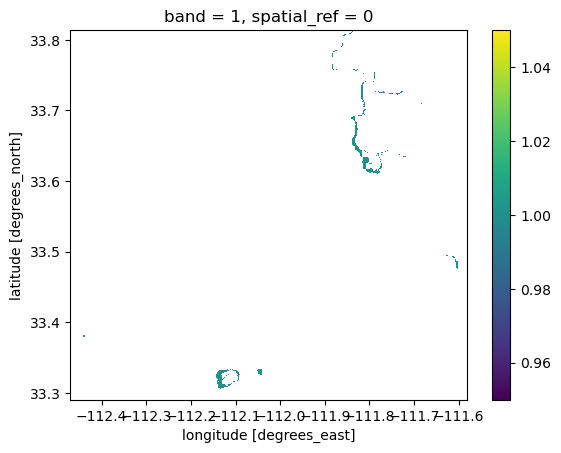

In [34]:
# Find the difference between areas >= 0.75 between 2017 and 2020 
phx_diff = (phoenix_2017_clip >= 0.75) ^ (phoenix_2020_clip >= 0.75)

# Assign zeroes to nan 
phx_diff = xr.where(phx_diff, 1, np.nan)

phx_diff.plot()

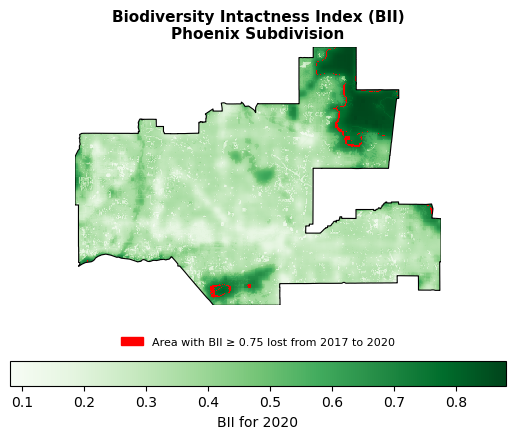

In [52]:
# Initialize figure
fig, ax = plt.subplots()

# Turn axis off for cleaner map
ax.axis('off')

#Plot phoenix boundary
phoenix_shp.boundary.plot(ax=ax,
                        color='black',
                        linewidth=0.8)


# Plot BII
phoenix_2020_clip.plot(ax=ax,
                        cmap='Greens',
                        cbar_kwargs = {'location':'bottom',
                                        'label': 'BII for 2020'})

# Plot difference in BII
phx_diff.plot(ax=ax, 
                cmap='brg',
                add_colorbar=False)

# Create custom legend for the BII difference
custom_legend = mpatches.Patch(color = "red", label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')

ax.legend(handles = [custom_legend], 
        loc = 'lower center',
        fontsize = 8, 
        frameon=False, 
        bbox_to_anchor=(0.5, -0.2))

# Set title and axes labels
ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision',
                fontsize=11, fontweight='bold')

plt.show()

From the map, we can see that the areas where BII >= 0.75 that Phoenix lost from 2017 to 2020 area also the areas in which the BII is the highest. It's possible that other parts of Phoenix also lost BII, but in 2017 if they were below the 0.75 threshold then they would not have been calculated for the difference. As we found earlier, the difference in area of BII >= 0.75 from 2017 to 2020 was about .64%, and in this map that is represented by the red. 